In [0]:
# Import required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,InputLayer
from sklearn.model_selection import train_test_split

In [0]:
# Download all ntlk resources

nltk.download('all')

In [0]:
# Import Sentiment140 dataset
# Update file location of Sentiment140.csv according to your working environment

data_path  = "Sentiment140.csv"

twitter_data = pd.read_csv(data_path,names=['target','id','date','flag','user','text'],
                           encoding = "ISO-8859-1")

In [0]:
# Create NumPy array of unprocessed input text and target 

X=np.array(twitter_data['text'])
Y=np.array(twitter_data['target'])

# Set Y=1 for Positive Tweets
Y[Y==4]=1

In [0]:
# Visualize Dataset

index = 123  # index in range [0,1599999]

print(X[index])

I am in pain. My back and sides hurt. Not to mention crying is made of fail. 


In [0]:
# Define Preprocessing functions

def tokenize(X):
  """
  Tokenize the data using nltk
  """

  treebank = nltk.tokenize.TreebankWordTokenizer()
  X_tokenized=[treebank.tokenize(sentence) for sentence in X]  
  return X_tokenized


def remove_stopwords(X):
  """
  Remove Stopwords using nltk
  """

  stopwords=nltk.corpus.stopwords.words('english') + ['@']
  X_without_stopwords = []

  for sentence in X:

    temp = [word for word in sentence if not word in stopwords]
    X_without_stopwords.append(temp) 

  return X_without_stopwords


def stem(X,type='porter'):
  """
  Perform Stemming using nltk
  type = 'Porter','Snowball','Lancaster'
  """
  
  if type == 'porter':
    stemmer= nltk.stem.PorterStemmer()
  elif type == 'snowball':
    stemmer = nltk.stem.SnowballStemmer()
  elif type == 'lancaster':
    stemmer = nltk.stem.LancasterStemmer()    

  
  X_stemmed = []

  for sentence in X:

    temp = [stemmer.stem(word) for word in sentence]
    X_stemmed.append(temp)

  return X_stemmed 



def get_wordnet_pos(treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return 'a'
        elif treebank_tag.startswith('V'):
            return 'v'
        elif treebank_tag.startswith('N'):
            return 'n'
        elif treebank_tag.startswith('R'):
            return 'r'
        else:
            return 'n'


def lemmatize(X):
  """
  Lemmatize words using corresponding POS tag
  """

  lemmatizer = nltk.stem.WordNetLemmatizer()
  
  X_pos = []
  X_lemmatized = []

  for sentence in X :

    temp = nltk.pos_tag(sentence)
    X_pos.append(temp)  

  for sentence in X_pos :

    temp = [ lemmatizer.lemmatize(word[0],pos=get_wordnet_pos(word[1])) for word in sentence]
    X_lemmatized.append(temp)  

  return X_lemmatized    

# **Training on Unprocessed data**


In [0]:
# Count total no. of distinct tokens

tokenizer = Tokenizer(filters='@')
tokenizer.fit_on_texts(X)

print('No. of distinct tokens = '+str(len(tokenizer.word_index)))

No. of distinct tokens = 1185412


In [0]:
# Define Vocabulary size (no. of most frequent tokens) to consider

max_vocab=50000

In [0]:
# Reload Twitter dataset with new Vocabulary

tokenizer = Tokenizer(num_words=max_vocab,filters='@')
tokenizer.fit_on_texts(X)

In [0]:
# Vectorize input text using Vocabulary

X_vectorized=tokenizer.texts_to_sequences(X)

In [0]:
# Count average length of tweets

sum=0
for sentence in X_vectorized:
  sum+=len(sentence)

print('Average length of tweets = '+str(sum/len(X_vectorized)))

Average length of tweets = 11.967963125


In [0]:
# Define Maximum input length of the Model

max_length=20

In [0]:
# Pad or Trim data to defined input length

X_pad = keras.preprocessing.sequence.pad_sequences(X_vectorized,max_length,padding='post',
                                                   truncating='post')

print(X_pad.shape)

(1600000, 20)


In [0]:
# Visualize unprocessed data

index  = 123  # index in range [0,1599999]

print('\nOriginal :')
print(X[index])
print('\nTokenized :')
print(X_tokenized[index])
print('\nVectorized :')
print(X_vectorized[index])
print('\nPadded :')
print(X_pad[index])


Original :
I am in pain. My back and sides hurt. Not to mention crying is made of fail. 

Tokenized :
['I', 'am', 'in', 'pain.', 'My', 'back', 'and', 'sides', 'hurt.', 'Not', 'to', 'mention', 'crying', 'is', 'made', 'of', 'fail', '.']

Vectorized :
[1, 57, 10, 2588, 5, 48, 6, 8826, 2898, 25, 2, 1418, 1086, 8, 187, 12, 2288]

Padded :
[   1   57   10 2588    5   48    6 8826 2898   25    2 1418 1086    8
  187   12 2288    0    0    0]


In [0]:
# Define Classification model

np.random.seed(123)

model_1 = keras.models.Sequential(name='Model_1(Sentiment140_Unprocessed)')

model_1.add(InputLayer(input_shape=(20,),name = 'Integer_Encoding'))
model_1.add(Embedding(max_vocab, 100,input_length=max_length,mask_zero=True,
                      name='100D_Encoding',trainable=False))
model_1.add(Bidirectional(LSTM(64,name='LSTM'),name='Bidirectional_RNN'))
model_1.add(Dropout(0.5,name='Regularizer'))
model_1.add(Dense(1, activation='sigmoid',name='Sigmoid_Classifier'))

In [0]:
# Compile the Model

model_1.compile(optimizer=keras.optimizers.adam(lr=0.001),loss='binary_crossentropy',
                metrics=['accuracy'])

Model: "Model_1(Sentiment140_Unprocessed)"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
100D_Encoding (Embedding)    (None, 20, 100)           5000000   
_________________________________________________________________
Bidirectional_RNN (Bidirecti (None, 128)               84480     
_________________________________________________________________
Regularizer (Dropout)        (None, 128)               0         
_________________________________________________________________
Sigmoid_Classifier (Dense)   (None, 1)                 129       
Total params: 5,084,609
Trainable params: 84,609
Non-trainable params: 5,000,000
_________________________________________________________________


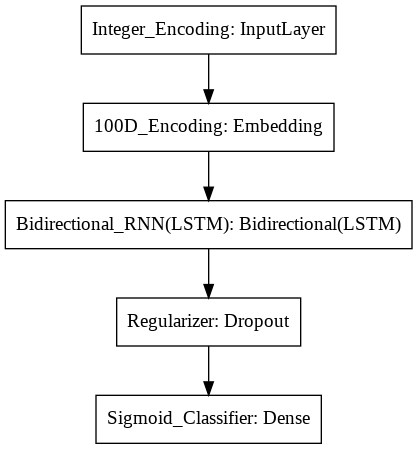

In [0]:
# Model details

model_1.summary()
keras.utils.plot_model(model_1,to_file='model_1.png')

In [0]:
# Perform train-test split

np.random.seed(123)

X_train, X_test, Y_train, Y_test = train_test_split (X_pad,Y.reshape(Y.shape[0],1),test_size=0.05)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1520000, 20)
(80000, 20)
(1520000, 1)
(80000, 1)


In [0]:
# Train the model

history_model_1 = model_1.fit(X_train,Y_train,batch_size=1024,epochs=15,validation_split=0.05)

Train on 1444000 samples, validate on 76000 samples
Epoch 1/15
1444000/1444000 [==============================] - 220s 153us/step - loss: 0.6372 - acc: 0.6355 - val_loss: 0.6100 - val_acc: 0.6638
Epoch 2/15
1444000/1444000 [==============================] - 218s 151us/step - loss: 0.5891 - acc: 0.6826 - val_loss: 0.5656 - val_acc: 0.7042
Epoch 3/15
1444000/1444000 [==============================] - 219s 152us/step - loss: 0.5555 - acc: 0.7109 - val_loss: 0.5406 - val_acc: 0.7218
Epoch 4/15
1444000/1444000 [==============================] - 219s 152us/step - loss: 0.5367 - acc: 0.7261 - val_loss: 0.5255 - val_acc: 0.7338
Epoch 5/15
1444000/1444000 [==============================] - 218s 151us/step - loss: 0.5239 - acc: 0.7363 - val_loss: 0.5134 - val_acc: 0.7428
Epoch 6/15
1444000/1444000 [==============================] - 218s 151us/step - loss: 0.5152 - acc: 0.7425 - val_loss: 0.5200 - val_acc: 0.7383
Epoch 7/15
1444000/1444000 [==============================] - 220s 153us/step - loss

In [0]:
# Evaluate model on Test data

model_1.evaluate(X_test,Y_test)

80000/80000 [==============================] - 13s 167us/step


[0.47721565170884134, 0.7687125]

# **Training on Pre-Processed data with GloVe Word Embeddings**



In [0]:
# Preprocess the data

X_tokenized = tokenize (X)

X_without_stopwords = remove_stopwords ( X_tokenized )

X_lemmatized = lemmatize ( X_without_stopwords )

X_clean = []

for sentence in X_lemmatized:

  temp = " ".join(sentence)
  X_clean.append(temp)

In [0]:
# Count total no. of distinct tokens

tokenizer = Tokenizer(filters='@')
tokenizer.fit_on_texts(X_clean)

print('No. of distinct tokens = '+str(len(tokenizer.word_index)))

No. of distinct tokens = 837032


In [0]:
# Define Vocabulary size (no. of most frequent tokens) to consider

max_vocab=50000

In [0]:
# Reload Twitter dataset with new Vocabulary

tokenizer = Tokenizer(num_words=max_vocab,filters='@')
tokenizer.fit_on_texts(X_clean)

In [0]:
# Vectorize input text using Vocabulary

X_clean_vectorized=tokenizer.texts_to_sequences(X_clean)

In [0]:
# Count average length of tweets

length=[]
for sentence in X_clean_vectorized:
  length.append(len(sentence))
  
print('Average length of tweets = '+str(np.mean(length)))

Average length of tweets = 10.064181875


In [0]:
# Define Maximum input length of the Model

max_length=20

In [0]:
# Pad or Trim data to defined input length

X_clean_pad = keras.preprocessing.sequence.pad_sequences(X_clean_vectorized,max_length,padding='post',
                                                         truncating='post')

print(X_clean_pad.shape)

(1600000, 20)


In [0]:
# Visualize pre-processed data

index  = 123  # index in range [0,1599999]

print('\nOriginal :')
print(X[index])
print('\nTokenized :')
print(X_tokenized[index])
print('\nStopwords removed :')
print(X_without_stopwords[index])
print('\nPOS tagged :')
print(nltk.pos_tag(X_without_stopwords[index]))
print('\nLemmatized :')
print(X_lemmatized[index])
print('\nClean :')
print(X_clean[index])
print('\nVectorized :')
print(X_clean_vectorized[index])
print('\nPadded :')
print(X_clean_pad[index])


Original :
I am in pain. My back and sides hurt. Not to mention crying is made of fail. 

Tokenized :
['I', 'am', 'in', 'pain.', 'My', 'back', 'and', 'sides', 'hurt.', 'Not', 'to', 'mention', 'crying', 'is', 'made', 'of', 'fail', '.']

Stopwords removed :
['I', 'pain.', 'My', 'back', 'sides', 'hurt.', 'Not', 'mention', 'crying', 'made', 'fail', '.']

POS tagged :
[('I', 'PRP'), ('pain.', 'VBP'), ('My', 'PRP$'), ('back', 'NN'), ('sides', 'NNS'), ('hurt.', 'VBP'), ('Not', 'RB'), ('mention', 'NN'), ('crying', 'VBG'), ('made', 'VBN'), ('fail', 'NN'), ('.', '.')]

Lemmatized :
['I', 'pain.', 'My', 'back', 'side', 'hurt.', 'Not', 'mention', 'cry', 'make', 'fail', '.']

Clean :
I pain. My back side hurt. Not mention cry make fail .

Vectorized :
[2, 3430, 62, 30, 591, 4231, 146, 831, 308, 33, 426, 4]

Padded :
[   2 3430   62   30  591 4231  146  831  308   33  426    4    0    0
    0    0    0    0    0    0]


In [0]:
# Load Pre-trained Word embeddings
# Update file location of glove.6B.100d.txt according to your working environment

embedding_path = 'glove.6B.100d.txt'

embeddings_index = dict()
f = open(embedding_path)
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()

In [0]:
# Create Word Embedding Matrix

embedding_matrix = np.zeros((max_vocab, 100))
for i in range(1,max_vocab):
	embedding_vector = embeddings_index.get(tokenizer.index_word[i])
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [0]:
# Define Classification model

np.random.seed(123)

model_2 = keras.models.Sequential(name='Model_2(Sentiment140_Preprocessed + GloVe 100D)')

model_2.add(InputLayer(input_shape=(20,),name='Integer_Encoding_after_Preprocessing'))
model_2.add(Embedding(max_vocab, 100, weights=[embedding_matrix], input_length=max_length,mask_zero=True,
                      name='Pretrained_GloVe_100D', trainable=False))
model_2.add(Bidirectional(LSTM(64,name='LSTM'),name='Bidirectional_RNN'))
model_2.add(Dropout(0.5,name='Regularizer'))
model_2.add(Dense(1, activation='sigmoid',name='Sigmoid_Classifier'))

In [0]:
# Compile the Model

model_2.compile(optimizer=keras.optimizers.adam(lr=0.001),loss='binary_crossentropy',
                metrics=['accuracy'])

Model: "Model_2(Sentiment140_Preprocessed + GloVe 100D)"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Pretrained_GloVe_100D (Embed (None, 20, 100)           5000000   
_________________________________________________________________
Bidirectional_RNN (Bidirecti (None, 128)               84480     
_________________________________________________________________
Regularizer (Dropout)        (None, 128)               0         
_________________________________________________________________
Sigmoid_Classifier (Dense)   (None, 1)                 129       
Total params: 5,084,609
Trainable params: 84,609
Non-trainable params: 5,000,000
_________________________________________________________________


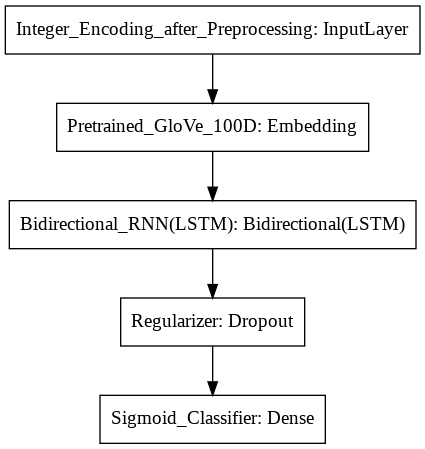

In [0]:
# Model details

model_2.summary()
keras.utils.plot_model(model_2,to_file='model_2.png')

In [0]:
# Perform train-test split

np.random.seed(123)

X_train, X_test, Y_train, Y_test = train_test_split (X_clean_pad,Y.reshape(Y.shape[0],1),test_size=0.05)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1520000, 20)
(80000, 20)
(1520000, 1)
(80000, 1)


In [0]:
# Train the model

history_model_2 = model_2.fit(X_train,Y_train,batch_size=1024,epochs=15,validation_split=0.05)

Train on 1444000 samples, validate on 76000 samples
Epoch 1/15
1444000/1444000 [==============================] - 217s 150us/step - loss: 0.5230 - acc: 0.7368 - val_loss: 0.4847 - val_acc: 0.7625
Epoch 2/15
1444000/1444000 [==============================] - 216s 150us/step - loss: 0.4789 - acc: 0.7686 - val_loss: 0.4664 - val_acc: 0.7754
Epoch 3/15
1444000/1444000 [==============================] - 216s 150us/step - loss: 0.4648 - acc: 0.7777 - val_loss: 0.4600 - val_acc: 0.7799
Epoch 4/15
1444000/1444000 [==============================] - 215s 149us/step - loss: 0.4560 - acc: 0.7834 - val_loss: 0.4554 - val_acc: 0.7829
Epoch 5/15
1444000/1444000 [==============================] - 216s 149us/step - loss: 0.4498 - acc: 0.7871 - val_loss: 0.4531 - val_acc: 0.7846
Epoch 6/15
1444000/1444000 [==============================] - 216s 150us/step - loss: 0.4450 - acc: 0.7902 - val_loss: 0.4452 - val_acc: 0.7891
Epoch 7/15
1444000/1444000 [==============================] - 216s 150us/step - loss

In [0]:
# Evaluate model on Test data

model_2.evaluate(X_test,Y_test)

80000/80000 [==============================] - 13s 166us/step


[0.4386945228159428, 0.7923375]

#**COMPARING BOTH MODELS**
###Model 1: Unprocessed data
###Model 2: Pre-processed data with GloVe Word Embeddings

In [0]:
# Calculate No. of epochs

n_epochs=len(history_model_1.history['loss'])
e = list(range(1,n_epochs+1))

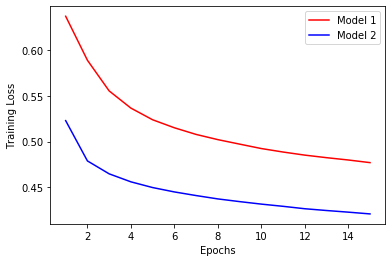

In [0]:
# Training Loss

plt.plot(e,history_model_1.history['loss'],'r',label='Model 1')
plt.plot(e,history_model_2.history['loss'],'b',label='Model 2')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

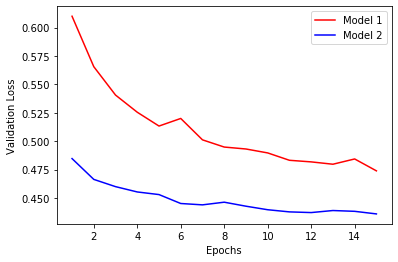

In [0]:
# Validation Loss

plt.plot(e,history_model_1.history['val_loss'],'r',label='Model 1')
plt.plot(e,history_model_2.history['val_loss'],'b',label='Model 2')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

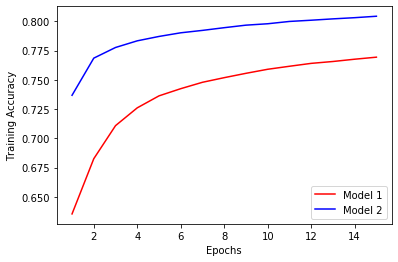

In [0]:
# Training Accuracy

plt.plot(e,history_model_1.history['acc'],'r',label='Model 1')
plt.plot(e,history_model_2.history['acc'],'b',label='Model 2')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

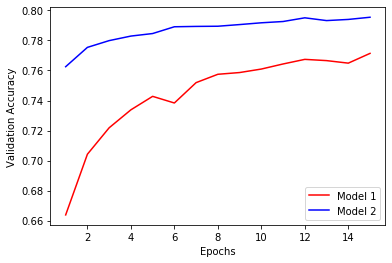

In [0]:
# Validation Accuracy

plt.plot(e,history_model_1.history['val_acc'],'r',label='Model 1')
plt.plot(e,history_model_2.history['val_acc'],'b',label='Model 2')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()